# GLODAP southern ocean analysis

:ship: :globe_with_meridians: :ship: :globe_with_meridians:

     1. What DIC and ALK observations are available in GLODAPv2.2021 for the southern ocean (<50lat)? how are they distributed in space and time?
    2. How does the evaluation of (regridded) DIC and ALK from T001(NCEP), M001(MetOffice) runs compare by season and depth?


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## data made in GLODAPv2021comparison 

look here for make/facts:
https://nbviewer.org/github/tjarnikova/SOZONE/blob/master/evalOutput/GLODAPv2021comparison_pipeline.ipynb

making new data for entire globe, also binning obs to lats & lons
it runs out of memory....


In [101]:
df = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL.csv')
df = df.sort_values(by = 'YR')
df

tDIC_SO = np.array(df['DIC'][:])
tALK_SO = np.array(df['ALK'][:])


tSAL_SO = np.array(df['SAL'][:])
tTEMP_SO = np.array(df['TEMP'][:])
tPRES_SO = np.array(df['PRES'][:])
tLAT_SO = np.array(df['LAT'][:])
tLON_SO = np.array(df['LON'][:])
tYEAR_SO = np.array(df['YR'])
tMONTH_SO = np.array(df['MONTH'])
tSECT_SO = np.array(df['SECT'])
tDP_SO = np.zeros_like(tSECT_SO)

### seasons
tSEAS_SO = np.zeros_like(tMONTH_SO)
tSEAS_SO[(tMONTH_SO == 12) | (tMONTH_SO <3)] = 1 #summer
tSEAS_SO[(tMONTH_SO >= 3) & (tMONTH_SO <6)] = 2 #autumn
tSEAS_SO[(tMONTH_SO >= 6) & (tMONTH_SO <9)] = 3 #winter
tSEAS_SO[(tMONTH_SO >= 9) & (tMONTH_SO <12)] = 4

## assign unique depth profiles numbers for ease

In [102]:
np.shape(np.unique(tLAT_SO))
np.shape(tLAT_SO)
print(np.shape(np.unique(tLON_SO)))

uniq_LATS = np.unique(tLAT_SO)

dpcount = 1
for i in range(0, len(uniq_LATS)):
    slat = uniq_LATS[i]
    
    corlons = np.unique(tLON_SO[tLAT_SO == slat])
    for j in range(0, len(corlons)):
        slon = corlons[j]
        coryrs = np.unique(tYEAR_SO[(tLAT_SO == slat) & (tLON_SO == slon)])
        for k in range(0, len(coryrs)):
            syr = coryrs[k]
            cormos = np.unique(tMONTH_SO[(tLAT_SO == slat) & (tLON_SO == slon) & (tYEAR_SO == syr)])
            tw = (np.shape(cormos)[0])
            for l in range(0, len(cormos)):
                smo = cormos[l]
                tDP_SO[(tLAT_SO == slat) & (tLON_SO == slon) & (tYEAR_SO == syr) & (tMONTH_SO == smo)] = dpcount
                dpcount = dpcount+1

print('unique depth profiles in SO:')
print(dpcount-1)
print(np.where(tDP_SO == 0))
print(np.max(tDP_SO))
tDP_SO = tDP_SO.astype(int)
print(np.max(tDP_SO))

(2346,)
unique depth profiles in SO:
3166
(array([], dtype=int64),)
3166.0
3166


## bin 2 grid

In [103]:
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
print(np.shape(tmask))
print('SO south of -50 is 0:37, SO south of -30 is 0:50')
lats = tmesh['nav_lat'][:,0]
lons = tmesh['nav_lon'][0,:]
deps = tmesh['gdept_1d'][0,:]


(149, 182)
SO south of -50 is 0:37, SO south of -30 is 0:50


In [104]:
print(np.min(tMONTH_SO))

1.0


In [131]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arval = array[idx]
    return(idx, arval)

# tlat = tLAT_SO[0]
# tlon = tLON_SO[0]
# print(tlat)
# print(tlon)

# idx, arval = find_nearest(lats, tlat)
# print(idx); print(arval)

tX_SO = np.zeros_like(tTEMP_SO)
tY_SO = np.zeros_like(tTEMP_SO)
tZ_SO = np.zeros_like(tTEMP_SO)
tZdep_SO = np.zeros_like(tTEMP_SO)


for i in range(0,len(tYEAR_SO)):
    tlat = tLAT_SO[i]
    tlon = tLON_SO[i]
    tdep = tPRES_SO[i]
    idx, arval = find_nearest(lats, tlat)
    tY_SO[i] = idx
    idx, arval = find_nearest(lons, tlon)
    tX_SO[i] = idx
    idx, arval = find_nearest(deps, tdep)
    tZ_SO[i] = idx
    tZdep_SO[i] = arval

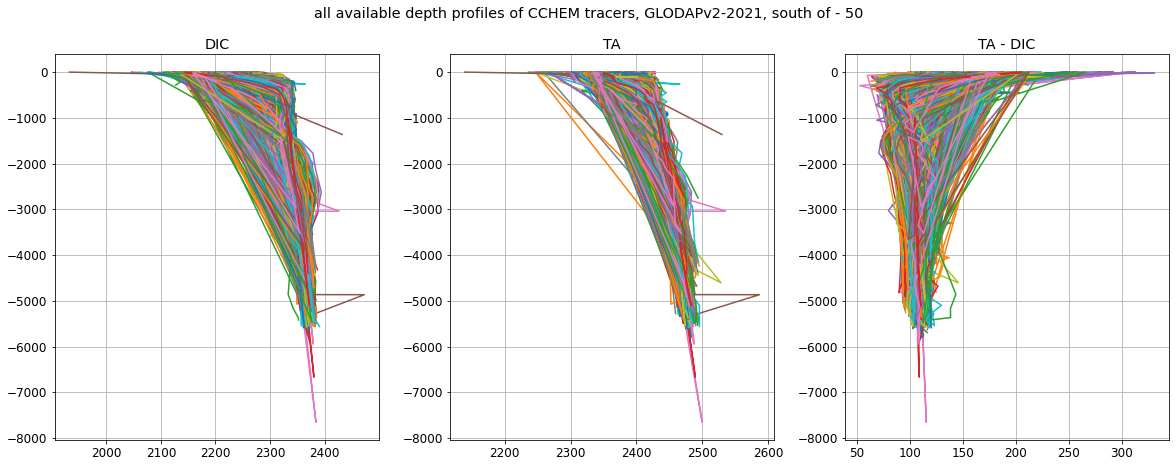

In [106]:
fact = 1.1
fig, axs = plt.subplots(1,3, figsize=(15*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
    

for i in range(0, max(tDP_SO)+1):
    tDIC = tDIC_SO[tDP_SO == i]
    tALK = tALK_SO[tDP_SO == i]
    #ta - dic is TAD
    tTAD = tALK-tDIC
    tPRES = tPRES_SO[tDP_SO == i]
    axs[0].plot(tDIC,-tPRES)
    axs[1].plot(tALK,-tPRES)
    axs[2].plot(tTAD,-tPRES)
    
tits = ['DIC', 'TA', 'TA - DIC'] 
for i in range(0,3):
    axs[i].grid()
    axs[i].set_title(tits[i])
plt.suptitle('all available depth profiles of CCHEM tracers, GLODAPv2-2021, south of - 50')
plt.tight_layout()

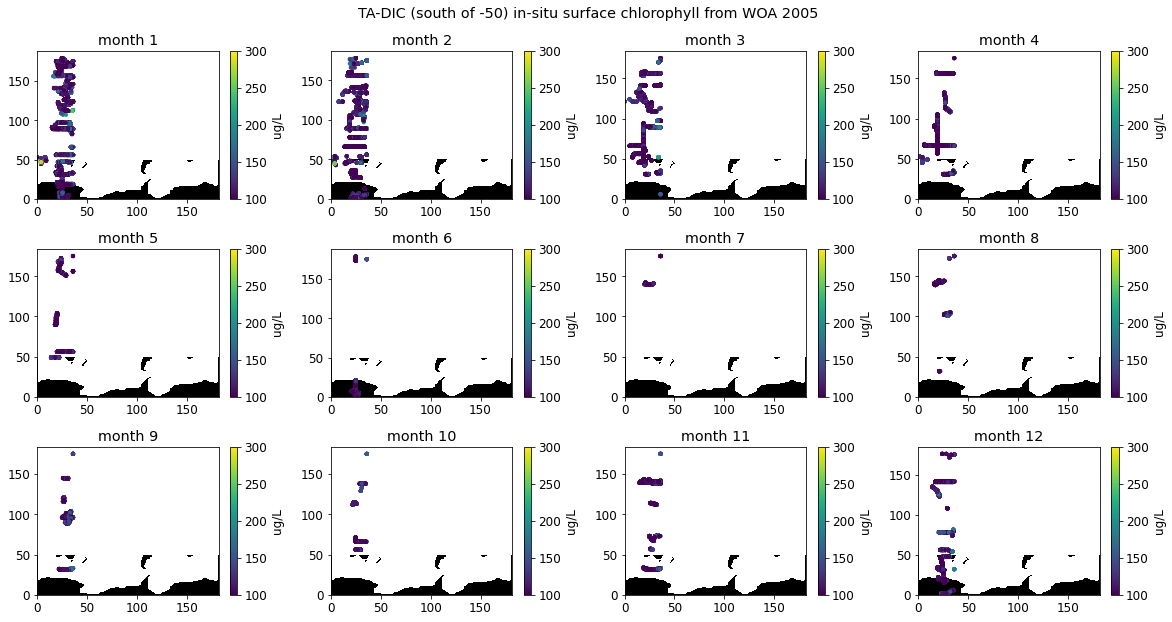

In [107]:
#plt.pcolormesh(tdat['CHL'][0,0,0:50,:])

fact = 1.1
fig, axs = plt.subplots(3,4, figsize=(15*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    q = axs[i].pcolormesh(tmask[0:50,:], vmin = 0, vmax = 1, cmap = 'Greys_r')
    q = axs[i].scatter(tY_SO[tMONTH_SO == i+1], tX_SO[tMONTH_SO == i+1],\
                       c = tALK_SO[tMONTH_SO == i+1]-tDIC_SO[tMONTH_SO == i+1], s = 10, vmin = 100, vmax = 300)
    plt.colorbar(q, ax = axs[i], label = 'ug/L')
    axs[i].set_title(f'month {i+1}')
plt.suptitle('TA-DIC (south of -50) in-situ surface chlorophyll from WOA 2005')
plt.tight_layout()

In [108]:
np.shape(tYEAR_SO[(tYEAR_SO>=1998) & (tYEAR_SO<=2011)])

(22030,)

In [109]:
np.max(tX_SO)

179.0

    here are the (python) y-indices and latitude bounds for my latitude bands:
    band 0, -78.2 to -69.5, index 0 to 16
    band 1, -69.5 to -59.3, index 16 to 28
    band 2, -59.3 to -48.8, index 28 to 37
    band 3, -48.8 to -38.7, index 37 to 44
    band 4, -38.7 to -28.7, index 44 to 50

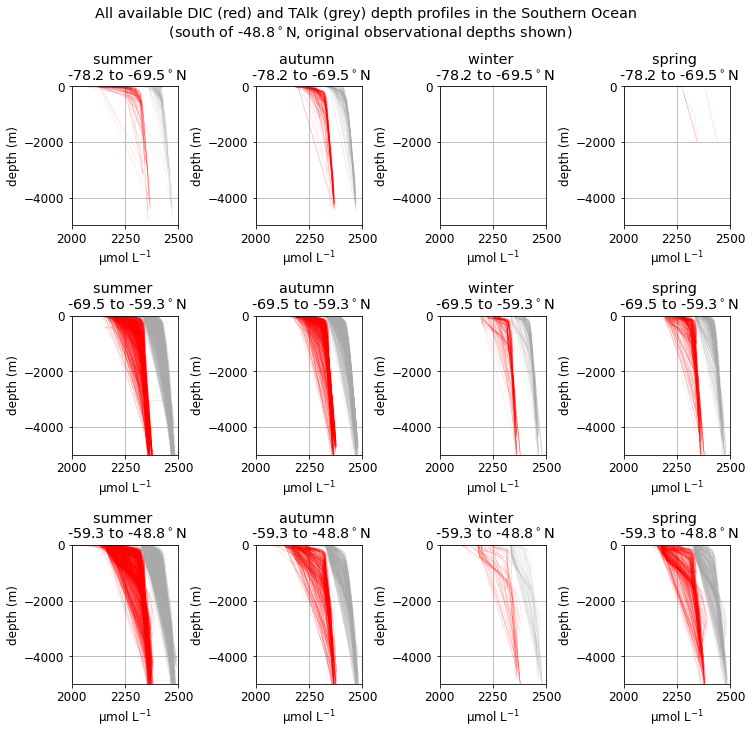

In [134]:
seasons = ['summer', 'autumn', 'winter', 'spring']

fact = 1.3
fig, axs = plt.subplots(3,4, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
        
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+4].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
         
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tDIC_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+8].plot(tplt, -tPRES, color = 'red', linewidth = 0.1, alpha = 0.7)
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
        
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+4].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
         
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37)  
    q = np.unique(tDP_SO[tfilt])
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]
        tPRES = tPRES_SO[tDP_SO == q[d]]
        axs[i+8].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')
    
    
    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([2000,2500])
    axs[i].set_ylim([-5000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')

plt.suptitle('All available DIC (red) and TAlk (grey) depth profiles in the Southern Ocean \n (south of -48.8$^\circ$N, original observational depths shown)')
plt.tight_layout()

In [160]:
def plot_all_profs(tfilt, ind):
    q = np.unique(tDP_SO[tfilt])
    storar = np.zeros([len(q),31]); storar[:] = np.nan
    for d in range(0,len(q)):
        tplt = tALK_SO[tDP_SO == q[d]]-tDIC_SO[tDP_SO == q[d]]
        tPRES = tZdep_SO[tDP_SO == q[d]]
        tZ = (tZ_SO[tDP_SO == q[d]]).astype('int')
        storar[d,tZ] = tplt
        axs[ind].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)

    axs[ind].plot(np.nanmean(storar, axis = 0), -deps, color = 'k', linewidth = 2)


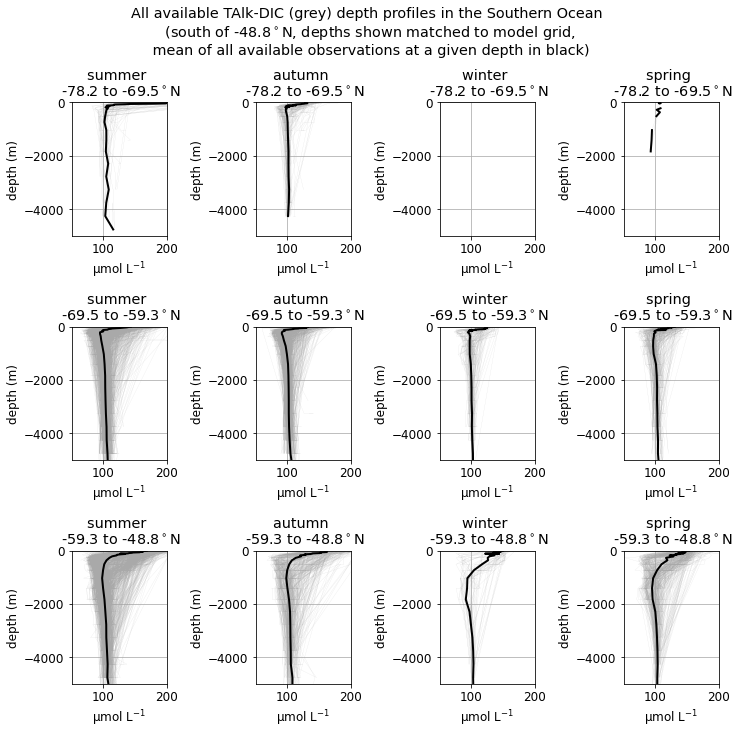

In [163]:
seasons = ['summer', 'autumn', 'winter', 'spring']

fact = 1.3
fig, axs = plt.subplots(3,4, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 0) & (tY_SO < 16); ind = i
    plot_all_profs(tfilt, ind)
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28); ind = i+4
    plot_all_profs(tfilt,ind)
for i in range(0,4):
    tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37); ind = i+8
    plot_all_profs(tfilt,ind)
# for i in range(0,4):
#     tfilt = (tSEAS_SO == i+1) & (tY_SO >= 16) & (tY_SO <= 28)  
#     q = np.unique(tDP_SO[tfilt])
#     for d in range(0,len(q)):
#         tplt = tALK_SO[tDP_SO == q[d]]-tDIC_SO[tDP_SO == q[d]]
#         tPRES = tZdep_SO[tDP_SO == q[d]]
#         axs[i+4].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
         
# for i in range(0,4):
#     tfilt = (tSEAS_SO == i+1) & (tY_SO >= 28) & (tY_SO <= 37)  
#     q = np.unique(tDP_SO[tfilt])
#     for d in range(0,len(q)):
#         tplt = tALK_SO[tDP_SO == q[d]]-tDIC_SO[tDP_SO == q[d]]
#         tPRES = tZdep_SO[tDP_SO == q[d]]
#         axs[i+8].plot(tplt, -tPRES, color = 'darkgrey', linewidth = 0.1, alpha = 0.7)
    
for i in range(0,4):
    axs[i].set_title(f'{seasons[i]} \n -78.2 to -69.5$^\circ$N')
    axs[i+4].set_title(f'{seasons[i]} \n -69.5 to -59.3$^\circ$N')
    axs[i+8].set_title(f'{seasons[i]} \n -59.3 to -48.8$^\circ$N')    
for i in range(0,12):
    axs[i].grid()
    axs[i].set_xlim([50,200])
    axs[i].set_ylim([-5000,0.1])
    axs[i].set_ylabel('depth (m)')
    axs[i].set_xlabel('µmol L$^{-1}$')

plt.suptitle('All available TAlk-DIC (grey) depth profiles in the Southern Ocean \n (south of -48.8$^\circ$N, depths shown matched to model grid, \n mean of all available observations at a given depth in black)')
plt.tight_layout()

[ 80.71243727  82.79727377  91.57074318  99.45107668 107.73391417
 124.98799658 131.4367664  131.61034321 142.54223543 143.02278177
 143.48520708]
[21 20 19 19 18 18 17 16 13  9  1]
[1033.21734145  732.20085553  511.53476547  511.53476547  364.30304026
  364.30304026  272.4767218   216.64791899  142.19524676   95.49428432
   15.00028841]
[  0.         143.48520708   0.           0.           0.
   0.           0.           0.           0.         143.02278177
   0.           0.           0.         142.54223543   0.
   0.         131.61034321 131.4367664  124.98799658  99.45107668
  82.79727377  80.71243727   0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]


In [ ]:
fact = 0.55
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 11
width = 0.9
axs[0].bar(yrs,OBS_depths[4,:],width, color = 'midnightblue', label = 'depth > 3000m')
axs[0].bar(yrs,OBS_depths[3,:],width, bottom = OBS_depths[4,:], color = 'b', label = '1000m < depth <= 3000m')
axs[0].bar(yrs,OBS_depths[2,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:], color = 'cornflowerblue', label = '500m < depth <= 1000m')
axs[0].bar(yrs,OBS_depths[1,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:], color = 'lightskyblue', label = '200m < depth <= 500m')
axs[0].bar(yrs,OBS_depths[0,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:]+OBS_depths[1,:], color = 'cyan', label = 'depth <= 200m')
axs[0].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[1].bar(yrs,OBS_seas[3,:],width,  color = 'magenta', label = 'winter')
axs[1].bar(yrs,OBS_seas[2,:],width, bottom = OBS_seas[3,:], color = 'goldenrod', label = 'autumn')
axs[1].bar(yrs,OBS_seas[1,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:], color = 'forestgreen', label = 'summer')
axs[1].bar(yrs,OBS_seas[0,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:]+OBS_seas[1,:], color = 'springgreen', label = 'spring')
axs[1].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[2].bar(yrs,OBS_sects[2,:],width,  color = 'b', label = 'pacific')
axs[2].bar(yrs,OBS_sects[1,:],width, bottom = OBS_sects[2,:], color = 'gold', label = 'indian')
axs[2].bar(yrs,OBS_sects[0,:],width, bottom = OBS_sects[2,:]+OBS_sects[1,:], color = 'r', label = 'atlantic')
axs[2].legend(ncol = 1, loc = 'best', fontsize = fs)
# ax.bar(x, diat_means, width, yerr=men_std, label='diat',color = 'r', alpha = 0.8)
# ax.bar(x, flag_means, width, yerr=women_std, bottom=diat_means,
#        label='flag', color = 'r', hatch='.', alpha = 0.6)

for i in range(0,3):
    axs[i].set_ylim([0,6100])
    axs[i].grid()
    axs[i].set_xlabel('years'); axs[i].set_ylabel('no. observations')

plt.suptitle('Valid DIC and TA measurements in the Southern Ocean (latitude < -50deg.) \n GLODAPv2.2021')
plt.tight_layout()

In [ ]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_DIC_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_dics_M001 = np.zeros_like(tDIC_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tdic = tDIC_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_dics_M001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_dics_T001 = np.zeros_like(tDIC_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tdic = tDIC_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_dics_T001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [ ]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_Alkalini_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_ALKs_M001 = np.zeros_like(tALK_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tALK = tALK_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_ALKs_M001[i] = (tnc['Alkalini'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_ALKs_T001 = np.zeros_like(tALK_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tALK = tALK_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_Alkalini_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_ALKs_T001[i] = (tnc['Alkalini'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [ ]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_votemper_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_TEMPs_M001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_TEMPs_M001[i] = (tnc['votemper'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_TEMPs_T001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_votemper_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_TEMPs_T001[i] = (tnc['votemper'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [ ]:
# now = datetime.now()
# print(now)

# td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_vosaline_1990_all.nc')
# lons = (td['lon'][:]-180)
# lats = (td['lat'][:])
# depths = (td['deptht'][:])

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     arval = array[idx]
#     return(idx, arval)

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
# mod_SALs_M001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_SALs_M001[i] = (tnc['vosaline'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr

# tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
# mod_SALs_T001 = np.zeros_like(tSAL_SO)
# for i in range(0,len(tYEAR_SO)):
#     tyr = tYEAR_SO[i]
#     tSAL = tSAL_SO[i]
#     tdepth = tPRES_SO[i]
#     tlat = tLAT_SO[i]
#     tlon = tLON_SO[i]
#     tmonth = tMONTH_SO[i]

#     if i == 0:
#         print(i)
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
#     elif (tyrold != tyr):
#         print(tyr)
#         tnc = nc.Dataset(f'{tdir}WOA_vosaline_{int(tyr)}_all.nc')
    
#     idx_d, arval = find_nearest(depths,tdepth)
#     idx_lat, arval = find_nearest(lats,tlat)
#     idx_lon, arval = find_nearest(lons,tlon)
    
#     mod_SALs_T001[i] = (tnc['vosaline'][tmonth-1,idx_d,idx_lat,idx_lon])
#     tyrold = tyr
    
# now2 = datetime.now()
# print(now2-now)


In [ ]:

# df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, mod_dics_M001, mod_ALKs_M001,mod_TEMPs_M001, mod_SALs_M001]).T
# df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT','mod_DIC','mod_ALK','mod_TEMP','mod_SAL']
# df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_M001.csv')
# df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO, mod_dics_T001, mod_ALKs_T001,mod_TEMPs_T001, mod_SALs_T001]).T
# df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT','mod_DIC','mod_ALK','mod_TEMP','mod_SAL']
# df.to_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_T001.csv')

In [ ]:
df_M001 = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_M001.csv')
df_T001 = pd.read_csv('./datasets/GLODAPv2.2021_SO_valid_DICTA_umolL_model_T001.csv')

tSAL_SO_conv = tSAL_SO * 35.16504/35

mod_DIC_M001 = np.array(df_M001['mod_DIC'][:])
mod_ALK_M001 = np.array(df_M001['mod_ALK'][:])
mod_TEMP_M001 = np.array(df_M001['mod_TEMP'][:])
mod_SAL_M001 = np.array(df_M001['mod_SAL'][:])
mod_DIC_T001 = np.array(df_T001['mod_DIC'][:])
mod_ALK_T001 = np.array(df_T001['mod_ALK'][:])
mod_TEMP_T001 = np.array(df_T001['mod_TEMP'][:])
mod_SAL_T001 = np.array(df_T001['mod_SAL'][:])

In [ ]:

fact = 0.37
fig, axs = plt.subplots(2,2, figsize=(22*fact, 22*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
mcol = 'steelblue'; tcol = 'red'
axs[0].scatter(tDIC_SO,mod_DIC_M001, marker = '.', c = mcol, s = 1, alpha = 0.5, label = 'M001/metoffice')
axs[0].scatter(tDIC_SO,mod_DIC_T001, marker = '.',c = tcol,s = 1, alpha = 0.5, label = 'T001/ncep')
axs[0].plot([2000,2500],[2000,2500],'k-')
axs[1].scatter(tALK_SO,mod_ALK_M001, marker = '.',c = mcol, s = 1,alpha = 0.5, label = 'M001/metoffice')
axs[1].scatter(tALK_SO,mod_ALK_T001, marker = '.',c = tcol, s = 1,alpha = 0.5, label = 'T001/ncep')
axs[1].plot([2000,2600],[2000,2600],'k-')
axs[2].scatter(tTEMP_SO,mod_TEMP_M001, marker = '.',c = mcol, s = 1,alpha = 0.5, label = 'M001/metoffice')
axs[2].scatter(tTEMP_SO,mod_TEMP_T001, marker = '.',c = tcol, s = 1,alpha = 0.5, label = 'T001/ncep')
axs[2].plot([-3,11],[-3,11],'k-')
axs[3].scatter(tSAL_SO,mod_SAL_M001, marker = '.',c = mcol, s = 1,alpha = 0.5)
axs[3].scatter(tSAL_SO,mod_SAL_T001, marker = '.',c = tcol, s = 1,alpha = 0.5)

axs[3].scatter(10,10, marker = '.',c = mcol, s = 40,alpha = 0.5, label = 'M001/metoffice')
axs[3].scatter(10,10, marker = '.',c = tcol, s = 40,alpha = 0.5, label = 'T001/ncep')
axs[3].plot([30,35],[30,35],'k-')


xmins = [2000,2100,-3,30]
xmaxs = [2500,2600,11,35]
tits = ['DIC','TA','temperature \n (note no conv between in-situ & cons.)','salinity (ref)']
axlab = ['obs. umol/L', 'obs.umol/L', 'obs. degC','obs. g/kg']
aylab = ['mod. umol/L', 'mod. umol/L', 'mod. degC','mod. g/kg']
for i in range(0,4):
    axs[i].grid()
    axs[i].set_title(tits[i])
    axs[i].set_xlim([xmins[i],xmaxs[i]])
    axs[i].set_ylim([xmins[i],xmaxs[i]])
    axs[i].set_xlabel(axlab[i]); axs[i].set_ylabel(aylab[i])
    
axs[3].legend()
fig.suptitle('SOUTHERN OCEAN GLODAP vs TOM12 model comparison \n DIC, TA, temp, sal (only  where valid DIC and TA exist)')
plt.tight_layout()

## selected model evaluation metrics:

#### bias
- (-np.mean(obs) + np.mean(mod))

#### RMSE
- (np.sqrt(np.sum((mod - obs)^2) /len(obs)))

#### Willmott Skill Score (WSS)
- nondimensional parametric score with range 0 - 1
- roughly model error divided by the range of the observations
- xbar = np.mean(obs)
- (1-(np.sum((mod - obs)^ 2 )  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar)) ^ 2)))

In [ ]:
def bias_box(obs,mod):
    bias = (-np.mean(obs) + np.mean(mod))
    return bias

def RMSE_box(obs,mod):
    RMSE = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    return RMSE

def WSS_box(obs,mod):
    xbar = np.mean(obs)
    WSS = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    return WSS

In [ ]:
mask = ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)
bias_M001_DIC = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
RMSE_M001_DIC = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
WSS_M001_DIC = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
bias_T001_DIC = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
RMSE_T001_DIC = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
WSS_T001_DIC = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask])

bias_M001_ALK = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
RMSE_M001_ALK = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
WSS_M001_ALK = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
bias_T001_ALK = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
RMSE_T001_ALK = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
WSS_T001_ALK = WSS_box(tALK_SO[mask],mod_ALK_T001[mask])

In [ ]:

depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,10000])
depth_tp = np.array([0, 12.5,60,300,750,1500,4000])

bias_bydepth_M001_DIC = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC = np.zeros_like(depthmins)
bias_bydepth_T001_DIC = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC = np.zeros_like(depthmins)
bias_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC_sum = np.zeros_like(depthmins)
bias_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC_sum = np.zeros_like(depthmins)
bias_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
RMSE_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
WSS_bydepth_M001_DIC_wint = np.zeros_like(depthmins)
bias_bydepth_T001_DIC_wint = np.zeros_like(depthmins)
RMSE_bydepth_T001_DIC_wint = np.zeros_like(depthmins)
WSS_bydepth_T001_DIC_wint = np.zeros_like(depthmins)

for i in range(0,len(depthmins)):
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i]))
    bias_bydepth_M001_DIC[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & ((tMONTH_SO==12) | (tMONTH_SO<=2))
    bias_bydepth_M001_DIC_sum[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC_sum[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC_sum[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC_sum[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC_sum[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC_sum[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    mask =( ~np.isnan(mod_DIC_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & (tMONTH_SO>5) & (tMONTH_SO<=8)
    bias_bydepth_M001_DIC_wint[i] = bias_box(tDIC_SO[mask],mod_DIC_M001[mask])
    RMSE_bydepth_M001_DIC_wint[i] = RMSE_box(tDIC_SO[mask],mod_DIC_M001[mask])
    WSS_bydepth_M001_DIC_wint[i] = WSS_box(tDIC_SO[mask],mod_DIC_M001[mask])
    bias_bydepth_T001_DIC_wint[i] = bias_box(tDIC_SO[mask],mod_DIC_T001[mask])
    RMSE_bydepth_T001_DIC_wint[i] = RMSE_box(tDIC_SO[mask],mod_DIC_T001[mask])
    WSS_bydepth_T001_DIC_wint[i] = WSS_box(tDIC_SO[mask],mod_DIC_T001[mask]) 
    


In [ ]:

depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,10000])
depth_tp = np.array([0, 12.5,60,300,750,1500,4000])

bias_bydepth_M001_ALK = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK = np.zeros_like(depthmins)
bias_bydepth_T001_ALK = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK = np.zeros_like(depthmins)
bias_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK_sum = np.zeros_like(depthmins)
bias_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK_sum = np.zeros_like(depthmins)
bias_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
RMSE_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
WSS_bydepth_M001_ALK_wint = np.zeros_like(depthmins)
bias_bydepth_T001_ALK_wint = np.zeros_like(depthmins)
RMSE_bydepth_T001_ALK_wint = np.zeros_like(depthmins)
WSS_bydepth_T001_ALK_wint = np.zeros_like(depthmins)

for i in range(0,len(depthmins)):
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i]))
    bias_bydepth_M001_ALK[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & ((tMONTH_SO==12) | (tMONTH_SO<=2))
    bias_bydepth_M001_ALK_sum[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK_sum[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK_sum[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK_sum[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK_sum[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK_sum[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    mask =( ~np.isnan(mod_ALK_M001) & ~np.isnan(mod_ALK_M001)\
    &  (tPRES_SO >=depthmins[i]) &   (tPRES_SO < depthmaxs[i])) & (tMONTH_SO>5) & (tMONTH_SO<=8)
    bias_bydepth_M001_ALK_wint[i] = bias_box(tALK_SO[mask],mod_ALK_M001[mask])
    RMSE_bydepth_M001_ALK_wint[i] = RMSE_box(tALK_SO[mask],mod_ALK_M001[mask])
    WSS_bydepth_M001_ALK_wint[i] = WSS_box(tALK_SO[mask],mod_ALK_M001[mask])
    bias_bydepth_T001_ALK_wint[i] = bias_box(tALK_SO[mask],mod_ALK_T001[mask])
    RMSE_bydepth_T001_ALK_wint[i] = RMSE_box(tALK_SO[mask],mod_ALK_T001[mask])
    WSS_bydepth_T001_ALK_wint[i] = WSS_box(tALK_SO[mask],mod_ALK_T001[mask]) 
    


In [ ]:
import matplotlib.ticker as mticker
depthmins = np.array([0.0,5,20,100,500,1000,2000])
depthmaxs = np.array([5.0,20,100,500,1000,2000,7000])
depth_tp = np.array([0.1, 12.5,60,300,750,1500,4000])
td = 1; ms = 20; lw = 2
fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(19*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,7):
    axs[2].text(0.01, depth_tp[i],f'{int(depthmins[i])}-{int(depthmaxs[i])}m')


axs[0].plot(bias_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2, label='M001\n (fullyr)')
axs[0].plot(bias_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2, label='T001\n (fullyr)')
axs[1].plot(RMSE_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[1].plot(RMSE_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[2].plot(WSS_bydepth_M001_DIC,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[2].plot(WSS_bydepth_T001_DIC,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[0].plot(bias_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':', label = 'M001 \n (summer)')
axs[0].plot(bias_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':', label = 'T001 \n (summer)')
axs[1].plot(RMSE_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[1].plot(RMSE_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[2].plot(WSS_bydepth_M001_DIC_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[2].plot(WSS_bydepth_T001_DIC_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[0].plot(bias_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--', label = 'M001 \n (winter)')
axs[0].plot(bias_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--', label = 'T001 \n (winter)')
axs[1].plot(RMSE_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[1].plot(RMSE_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[2].plot(WSS_bydepth_M001_DIC_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[2].plot(WSS_bydepth_T001_DIC_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')

axs[0].plot(bias_M001_DIC,td, color = mcol , marker = '*', markersize = ms, linestyle = '', label = 'M001 ALL')
axs[0].plot(bias_T001_DIC,td, color = tcol , marker = '*', markersize = ms, linestyle = '', label = 'T001 ALL')
axs[1].plot(RMSE_M001_DIC,td, color = mcol , marker = '*', markersize = ms)
axs[1].plot(RMSE_T001_DIC,td, color = tcol , marker = '*', markersize = ms)
axs[2].plot(WSS_M001_DIC,td, color = mcol , marker = '*', markersize = ms)
axs[2].plot(WSS_T001_DIC,td, color = tcol , marker = '*', markersize = ms)

#####
axs[3].plot(bias_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[3].plot(bias_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[4].plot(RMSE_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[4].plot(RMSE_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[5].plot(WSS_bydepth_M001_ALK,depth_tp, color = mcol , marker = 'o', linewidth = lw+2)
axs[5].plot(WSS_bydepth_T001_ALK,depth_tp, color = tcol , marker = 'o', linewidth = lw+2)
axs[3].plot(bias_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[3].plot(bias_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[4].plot(RMSE_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[4].plot(RMSE_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[5].plot(WSS_bydepth_M001_ALK_sum,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[5].plot(WSS_bydepth_T001_ALK_sum,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = ':')
axs[3].plot(bias_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[3].plot(bias_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[4].plot(RMSE_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[4].plot(RMSE_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[5].plot(WSS_bydepth_M001_ALK_wint,depth_tp, color = mcol , marker = 'o', linewidth = lw, linestyle = '--')
axs[5].plot(WSS_bydepth_T001_ALK_wint,depth_tp, color = tcol , marker = 'o', linewidth = lw, linestyle = '--')

axs[3].plot(bias_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[3].plot(bias_T001_ALK,td, color = tcol , marker = '*', markersize = ms)
axs[4].plot(RMSE_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[4].plot(RMSE_T001_ALK,td, color = tcol , marker = '*', markersize = ms)
axs[5].plot(WSS_M001_ALK,td, color = mcol , marker = '*', markersize = ms)
axs[5].plot(WSS_T001_ALK,td, color = tcol , marker = '*', markersize = ms)

axs[0].axvline(x=0,color = 'k', linestyle = '-')
axs[3].axvline(x=0,color = 'k', linestyle = '-')

axs[0].legend(loc = 'best', fontsize = 10)

tits= ['bias (DIC)', 'RMSE (DIC)', 'WSS (DIC)','bias (ALK)', 'RMSE (ALK)', 'WSS (ALK)']
xlb= ['umol/L', 'umol/L', '','umol/L', 'umol/L', '']
xmi = [-20,15,0,-20,15,0]; xma = [80,80,1,80,80,1]
for i in range(0,6):
    axs[i].set_yscale('log')
    axs[i].invert_yaxis()
    axs[i].grid(); axs[i].set_title(tits[i])
    axs[i].set_xlim([xmi[i],xma[i]])
    axs[i].set_xlabel(xlb[i])
    axs[i].set_ylabel('depth (m)')
    
fig.suptitle('model evaluation metrics by depth and season, PLANKTOM12 against GLODAP2021v2, lat <-50deg \n depth ranges shown on 3rd plot, star represents all model data')
plt.tight_layout()
#axs[0].yaxis.set_major_formatter(mticker.ScalarFormatter())


In [ ]:
print('  compute complete: beep boop ')